# Phân loại khách hàng sử dụng K-means
- Dataset overview:
* Customer ID: Mã khách hàng - trường này có thể drop vì nó không hữu ích trong việc huấn luyện.
* Gender: Giới tính khách hàng (Nam/ nữ) - không có giới tính khác.
* Age: Độ tuổi của khách hàng (tập trung từ 18-70 tuổi)
* Annual Income: Thu nhập của khách hàng (trong khoảng 13-137) cơ bản là không có outlier
* Spending Score: Điểm chi tiêu của khách hàng (từ 1-99)

# Import libraries

In [69]:
import pandas as pd

import numpy as np
from numpy import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

import seaborn as sns
plt.style.use('fivethirtyeight')

In [70]:
from sklearn.preprocessing import StandardScaler

# Load data

In [71]:
dataset = pd.read_csv('./Dataset/Mall_Customers.csv')
dataset.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [72]:
# xóa column id và rename
df = dataset.drop('CustomerID', axis=1)
df.columns = ['Gender', 'Age', 'Income', 'Score']
df.head(5)

,Gender,Age,Income,Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [73]:
# mô tả data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  200 non-null    object
 1   Age     200 non-null    int64 
 2   Income  200 non-null    int64 
 3   Score   200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [74]:
# kiểm tra missing data
df.isnull().sum()

Gender    0
Age       0
Income    0
Score     0
dtype: int64

-> Tổng quan thì dữ liệu này khá là đẹp, đẹp như một bức tranh

# Visualizations để hiểu thêm về dữ liệu đầu vào trước khi phân cụm khách hàng.

## Phân tích phân bố của giới tính khách hàng

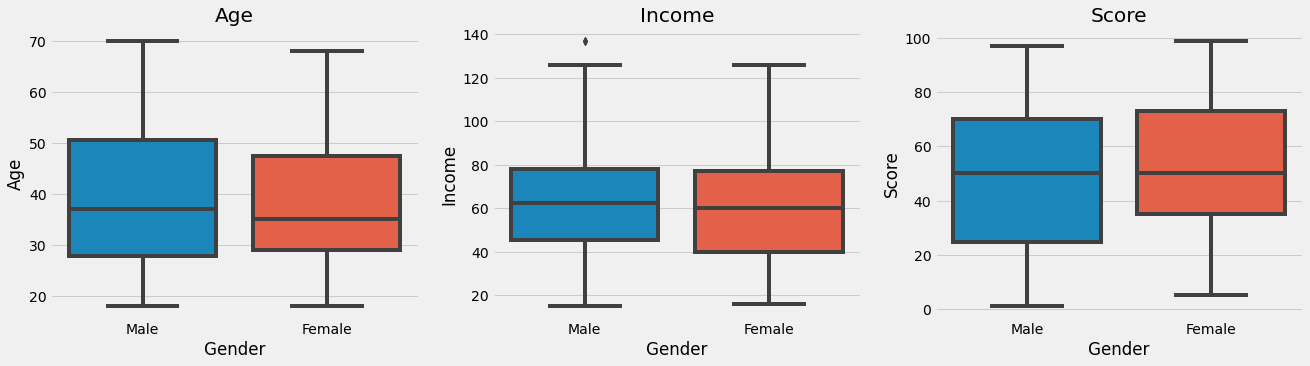

In [75]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.boxplot(x=df.Gender, y=df.Age)
plt.title('Age')

plt.subplot(1,3,2)
sns.boxplot(x=df.Gender, y=df.Income)
plt.title('Income')

plt.subplot(1,3,3)
sns.boxplot(x=df.Gender, y=df.Score)
plt.title('Score')

plt.show()

-> Nhìn vào Boxplot3 này ta có thẻ thấy nữ có điểm chi tiêu cao hơn so với nam. (và thực tế là nữ thich đến trung tâm mua săm hơn nam thật)

## Kiểm ta mối quan hệ giữa các feature để xem có gì hay?

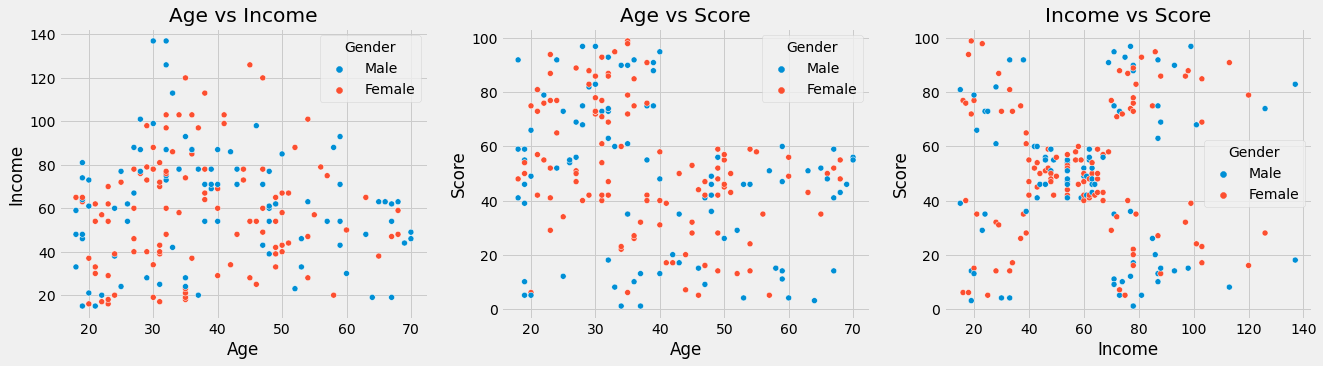

In [76]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.scatterplot(x=df.Age, y=df.Income, hue=df.Gender)
plt.title('Age vs Income')

plt.subplot(1,3,2)
sns.scatterplot(x=df.Age, y=df.Score, hue=df.Gender)
plt.title('Age vs Score')

plt.subplot(1,3,3)
sns.scatterplot(x=df.Income, y=df.Score, hue=df.Gender)
plt.title('Income vs Score')

plt.show()

- Nhìn vào biểu đồ độ tuổi và điểm chi tiêu: Ta có thể thấy nó trung niên từ 18-40 có sở thích đi mua đồ nhiều hơn so với độ tuổi trung niên (không còn thích đi shopping nữa)
- Còn với biểu đồ giữa thu nhập và điểm chi tiêu:  Ta thấy 5 nhóm khách hàng rõ dàng đã được hiện ra (đây cũng có thể lựa chọn làm ý tưởng để phân cụm)

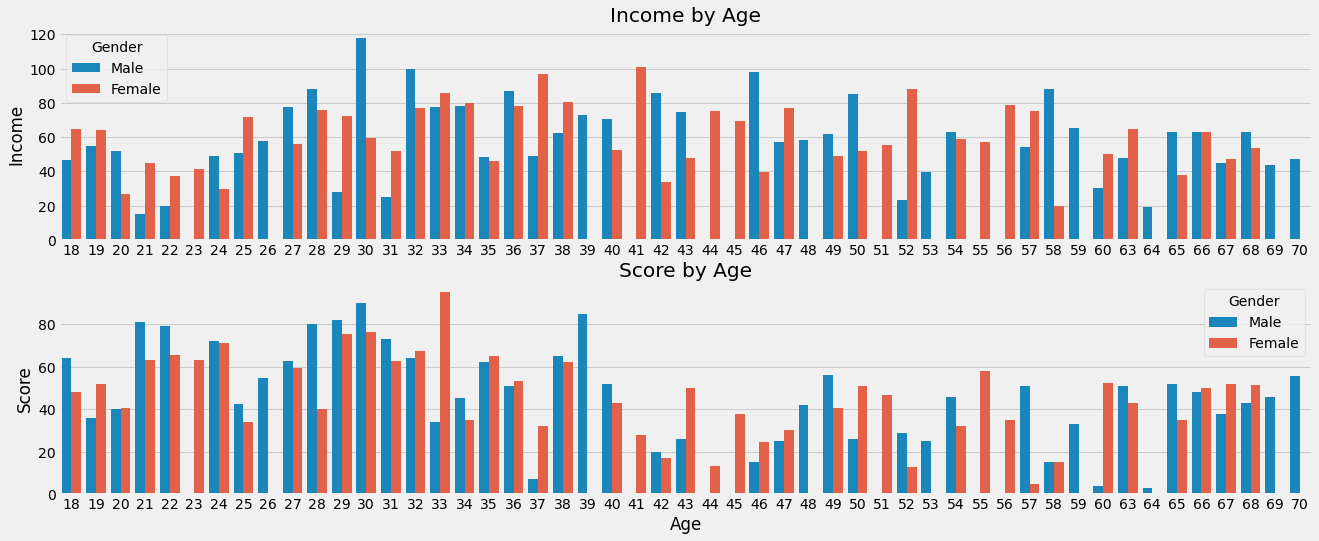

In [77]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
sns.barplot(x=df.Age, y=df.Income, hue=df.Gender, ci=0)
plt.title('Income by Age')
plt.xlabel('')

plt.subplot(2,1,2)
sns.barplot(x=df.Age, y=df.Score, hue=df.Gender, ci=0)
plt.title('Score by Age')

plt.show()

- Ta thấy rằng nhóm khách hàng ở độ tuổi từ 25-40 có thu nhập khá cao, do vậy điểm chi tiêu của họ ở trung tâm thương mại cũng hào phóng hơn.
- Ở những độ tuổi thanh niên, thì đàn ông có vẻ chi tiêu nhiều cho việc đi shopping (dẫn bạn gái đi mua đồ ...) Nhưng khi ở độ tuổi từ 30 khi đã lập gia đình thì nóc nhà sẽ thường đi mua đồ cho gia đình -> điểm chi tiêu của nữ giới ở độ tuổi ngoài 30 cao hơn nam)

# Dendrogram Plot
Biểu đồ thể hiện quan hệ thứ bậc(cluster tree) giữa những đối tượng. Giúp nhìn ra cách tốt nhất để phân bố các đôi tượng vào các cụm.

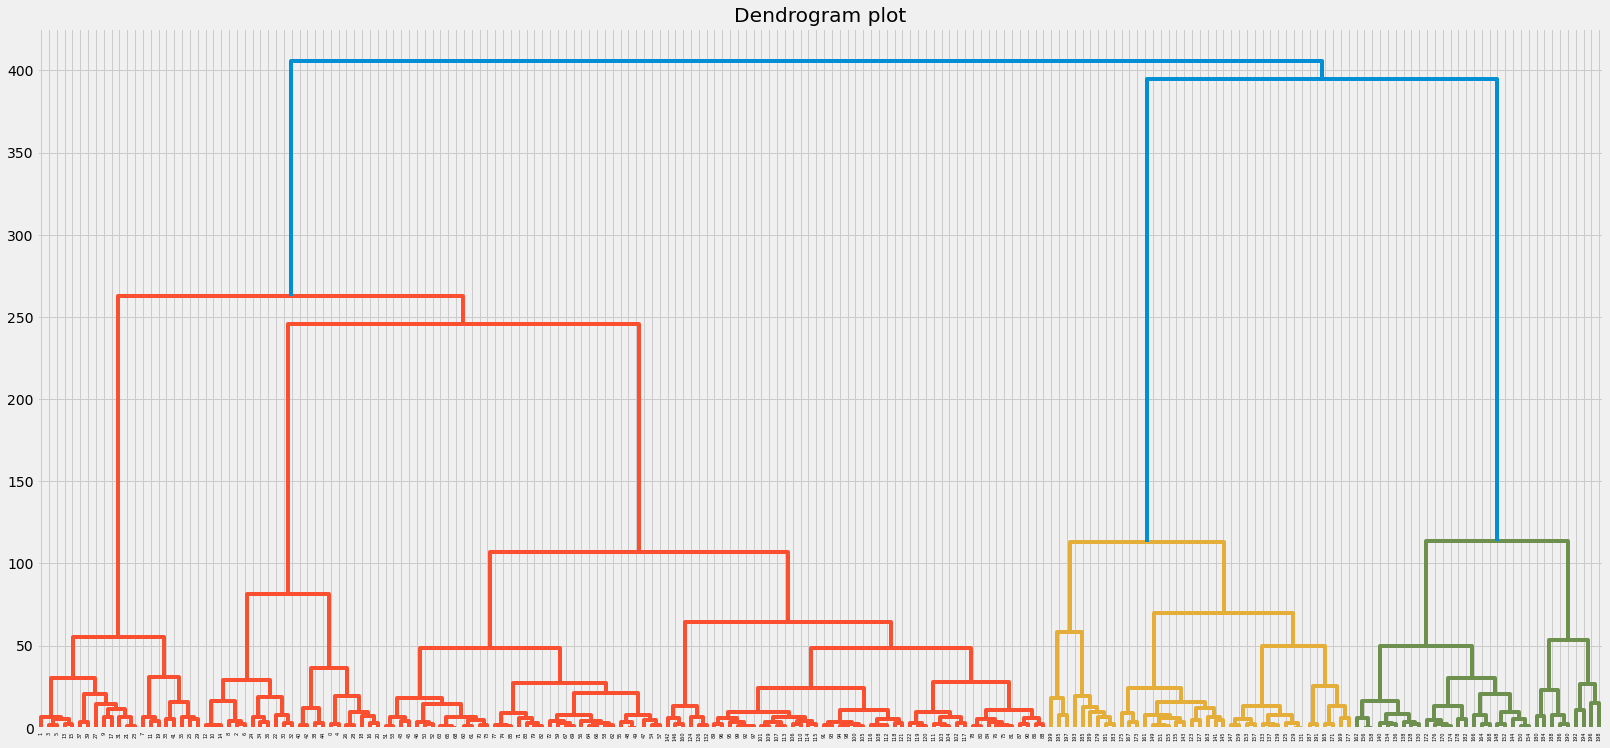

In [85]:
import scipy.cluster.hierarchy as sch
X=dataset.iloc[:, [3, 4]].values
plt.figure(figsize=(25,12))
dendrogram=sch.dendrogram(sch.linkage(X,method = 'ward'))
plt.title('Dendrogram plot')
plt.show()

In [78]:
# # one hot encoding, keeping just male column, so 1 = male, 0 = female
# df = pd.get_dummies(df, columns=['Gender'], drop_first=True)       #Thanks to Evan for suggestion
# df = df.rename(columns={'Gender_Male':'Gender'})

In [79]:
class KMeans ():
    def __init__(self, X, clusters, seed, iterations=300):
        random.seed(seed)

        self.K = clusters
        self.X = X
        self.iterations = iterations
        self.features = X.shape[1]
        self.data_size = X.shape[0]

    def initRandomCentroids(self, X):
        centroids = np.zeros((self.K, self.features))
        for k in range(self.K):
            centroid = X[np.random.choice(range(self.data_size))]
            centroids[k] = centroid
        return centroids

    def intClusters(self, X, centroids):
        # Will contain a list of the points that are associated with that specific cluster
        clusters = [[] for _ in range(self.K)]

        # Loop through each point and check which is the closest cluster
        for point_idx, point in enumerate(X):
            closest_centroid = np.argmin(
                np.sqrt(np.sum((point - centroids) ** 2, axis=1))
            )
            clusters[closest_centroid].append(point_idx)
        return clusters

    def calculateNewCentroids(self, clusters, X):
        centroids = np.zeros((self.K, self.features))
        for idx, cluster in enumerate(clusters):
            new_centroid = np.mean(X[cluster], axis=0)
            centroids[idx] = new_centroid
        return centroids

    def predictCluster(self, clusters, X):
        y_pred = np.zeros(self.data_size)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                y_pred[sample_idx] = cluster_idx
        return y_pred

    def labledData(self, X, y_pred):
        labeled_data = {}
        X_list = X.tolist()
        for i in range(y_pred.size):
            if y_pred[i] not in labeled_data:
                labeled_data[y_pred[i]] = [X_list[i]]
            else:
                labeled_data[y_pred[i]].append(X_list[i])

        for key in labeled_data:
            np_labled_data = labeled_data[key]
        return labeled_data

    # fit
    def fit(self):
        centroids = self.initRandomCentroids(self.X)

        for it in range(self.iterations):
            clusters = self.intClusters (self.X, centroids)

            previous_centroids = centroids
            centroids = self.calculateNewCentroids(clusters, self.X)

            diff = centroids - previous_centroids

            if not diff.any():
                break

        # Get label predictions
        y_pred = self.predictCluster(clusters, self.X)

        # Get labeled data
        labeled_data = self.labledData(self.X, y_pred)

        wcss=0
        for k in range(self.K):
            wcss+=np.sum((np.array(labeled_data[k])-centroids[k])**2)

        return y_pred, centroids, wcss

In [80]:
def plotEbow(X, K, seed):
    wcss_array = []
    for k in range(1, K):
        y, centroids, wcss = KMeans(X, k, seed).fit()
        wcss_array = np.append(wcss_array, wcss)

    plt.plot(np.arange(1, K), wcss_array, "-o")
    plt.plot(np.arange(1, K), wcss_array, 'D', markersize=8)

    plt.xlabel('Number of Clusters')
    plt.ylabel('within-cluster sums of squares (WCSS)')
    plt.title('Elbow method to determine optimum number of clusters')
    plt.show()

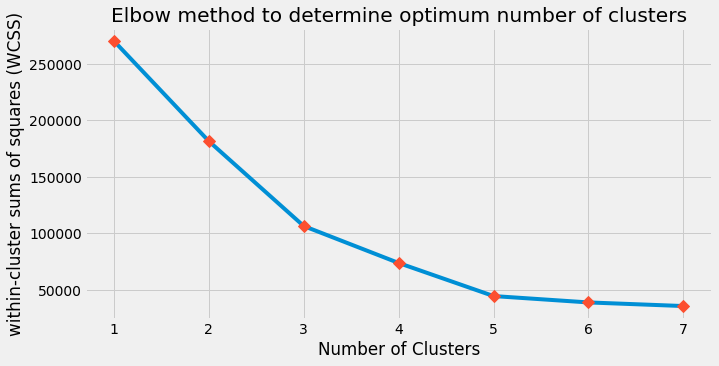

In [81]:
# Choose your seed
seed=69
X = dataset.iloc[:, [3, 4]].values
plotEbow(X, 8, seed)

In [82]:
# Cluster and add label to dataset
model =  KMeans(X, 5, seed)
Y, centroids, wcss = model.fit()
Y = Y.astype(int)

dataset['Label'] = Y.tolist()
dataset

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Label
0,1,Male,19,15,39,0
1,2,Male,21,15,81,2
2,3,Female,20,16,6,0
3,4,Female,23,16,77,2
4,5,Female,31,17,40,0
...,...,...,...,...,...,...
195,196,Female,35,120,79,3
196,197,Female,45,126,28,4
197,198,Male,32,126,74,3
198,199,Male,32,137,18,4


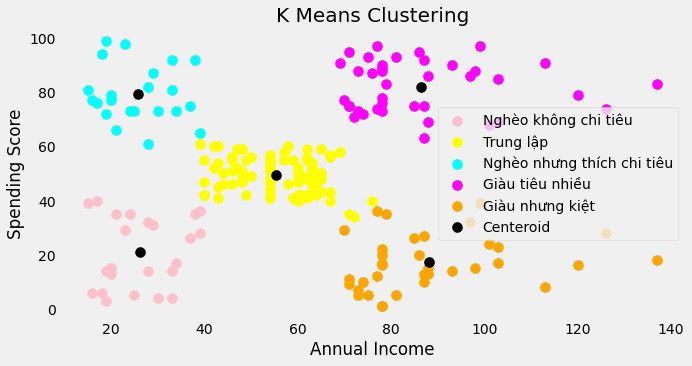

In [83]:
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], s = 100, c = 'pink', label = 'Nghèo không chi tiêu')
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], s = 100, c = 'yellow', label = 'Trung lập')
plt.scatter(X[Y == 2, 0], X[Y == 2, 1], s = 100, c = 'cyan', label = 'Nghèo nhưng thích chi tiêu')
plt.scatter(X[Y == 3, 0], X[Y == 3, 1], s = 100, c = 'magenta', label = 'Giàu tiêu nhiều')
plt.scatter(X[Y == 4, 0], X[Y == 4, 1], s = 100, c = 'orange', label = 'Giàu nhưng kiệt')
plt.scatter(centroids[:,0], centroids[:, 1], s = 100, c = 'black' , label = 'Centeroid')

plt.style.use('fivethirtyeight')
plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.grid()
plt.show()
plt.show()